# Well Train

In [59]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
#import petrophysics as ptr
import math as math

# import sklearn libararies
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import NearestNeighbors

# data reading
data = pd.read_csv('train.csv')
temp_CAL=data['CAL']
temp_CAL[data['CAL']>8.7]=np.NaN #8.5 >8.875#8.7813
temp_CAL[data['CAL']<8.5]=np.NaN
data['CAL']=temp_CAL
data.describe()

,CAL,CNC,GR,HRD,HRM,PE,ZDEN,DTC,DTS
count,10588.000000,30143.000000,30143.000000,30143.000000,30143.000000,30143.000000,30143.000000,30143.000000,30143.000000
mean,8.603602,-23.692615,38.959845,3.977690,1.547299,-17.446739,-20.229982,-54.891703,-9.737567
std,0.040882,157.142679,108.504554,365.112753,456.908969,149.083136,148.809506,372.858812,440.314119
min,8.500000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000
25%,8.578100,0.122800,17.248750,0.717700,0.712050,0.053100,2.226700,66.304350,118.534350
50%,8.605900,0.193600,36.821800,1.623000,1.628100,4.941500,2.432200,78.355100,137.689300
75%,8.625000,0.337150,58.346150,3.158300,3.280600,7.856650,2.551350,107.022500,182.973150
max,8.699800,3490.158200,1470.253400,10000.000000,60467.761700,28.106400,3.259700,155.980300,487.438400


In [60]:
def result_plot(y_predict, y_real):
    # check the accuracy of predicted data and plot the result
    print('Root Mean Square Error is:', '{:.5f}'.format(np.sqrt(mean_squared_error(y_real, y_predict))))
    plt.subplots(nrows=2, ncols=2, figsize=(16,10))
    plt.subplot(1, 2, 1)
    plt.plot(y_real,color='black')
    plt.plot(y_predict,color='red')
    plt.legend(['True', 'Predicted'])
    plt.xlabel('Sample')
    plt.ylabel('DTC')
    plt.title('Transit Time Prediction Comparison')

    plt.subplot(1, 2, 2)
    plt.scatter(y_real, y_predict)
    plt.xlabel('Real Value')
    plt.ylabel('Predicted Value')
    plt.title('Transit Time Prediction Comparison')
    
    plt.show()

In [61]:
data_train_dtc=data[['CAL','CNC','GR','HRD','HRM','PE','ZDEN','DTC']]#[['CAL','CNC','GR','HRD','HRM','PE','ZDEN','DTC']]
data_train_dtc.replace(['-999', -999], np.NaN, inplace=True)
data_train_dtc.dropna(axis=0, inplace=True)

data_train_dts=data[['CAL','CNC','GR','HRD','HRM','PE','ZDEN','DTS']]
data_train_dts.replace(['-999', -999], np.NaN, inplace=True)
data_train_dts.dropna(axis=0, inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4172: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

In [62]:
data_train_dtc.describe()

,CAL,CNC,GR,HRD,HRM,PE,ZDEN,DTC
count,10435.000000,10435.000000,10435.000000,10435.000000,10435.000000,10435.000000,10435.00000,10435.000000
mean,8.603555,0.237925,46.637043,3.027475,9.235376,0.541727,2.46733,78.053445
std,0.040272,4.290627,63.095899,3.187275,591.954231,2.246628,0.15857,14.035919
min,8.500000,0.029000,1.038900,0.123600,0.134100,-0.023200,-0.87190,56.382300
25%,8.578100,0.104050,11.617750,1.073400,1.130550,0.045600,2.34390,68.107850
50%,8.601600,0.146500,32.231300,2.613100,2.825000,0.050000,2.53000,73.820800
75%,8.625000,0.227550,48.550150,3.776000,4.230650,0.055600,2.57995,88.900700
max,8.699800,365.885000,587.060900,206.718200,60467.761700,20.987300,2.93150,135.285700


In [63]:
data_train_dts.describe()

,CAL,CNC,GR,HRD,HRM,PE,ZDEN,DTS
count,10061.000000,10061.000000,10061.000000,10061.000000,10061.000000,10061.000000,10061.000000,10061.000000
mean,8.605096,0.234099,47.978421,4.374449,10.342580,0.164777,2.480117,141.373480
std,0.039705,4.369412,66.832490,102.440987,607.626319,0.859050,0.143296,27.217463
min,8.500000,0.029000,1.038900,0.064500,0.073900,-0.023200,1.980600,96.900500
25%,8.578100,0.101400,11.218900,1.304000,1.421700,0.045400,2.402000,122.264900
50%,8.625000,0.142500,32.316300,2.685700,2.940600,0.049700,2.536700,133.425100
75%,8.625000,0.216000,49.298100,3.858400,4.342300,0.054900,2.582300,148.187500
max,8.699800,365.885000,1342.082800,10000.000000,60467.761700,20.987300,2.931500,261.785900


In [64]:
# Outliers detection dtc
dbscan_data=data_train_dtc
dbscan_data=dbscan_data.values.astype('float32',copy=False)
dbscan_data_scaler=StandardScaler().fit(data_train_dtc)
dbscan_data_transformed=dbscan_data_scaler.transform(data_train_dtc)
model=DBSCAN(eps=0.3, min_samples=12,metric='euclidean').\
    fit(dbscan_data_transformed)
# Outliers removal
outliers_df=dbscan_data_transformed[model.labels_ == -1]
clusters_df=dbscan_data_transformed[model.labels_ != -1]
data_train_dtc[model.labels_ == -1]=np.NaN
data_train_dtc.dropna(axis=0, inplace=True)

# Outliers detection dts
dbscan_data=data_train_dts
dbscan_data=dbscan_data.values.astype('float32',copy=False)
dbscan_data_scaler=StandardScaler().fit(data_train_dts)
dbscan_data_transformed=dbscan_data_scaler.transform(data_train_dts)
model=DBSCAN(eps=0.3, min_samples=12,metric='euclidean').\
    fit(dbscan_data_transformed)
# Outliers removal
outliers_df=dbscan_data_transformed[model.labels_ == -1]
clusters_df=dbscan_data_transformed[model.labels_ != -1]
data_train_dts[model.labels_ == -1]=np.NaN
data_train_dts.dropna(axis=0, inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:2957: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.loc._setitem_with_indexer(indexer, value)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:2935: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

In [65]:
data_train_dtc.describe()

,CAL,CNC,GR,HRD,HRM,PE,ZDEN,DTC
count,8876.000000,8876.000000,8876.000000,8876.000000,8876.000000,8876.00000,8876.000000,8876.000000
mean,8.604201,0.157666,40.245461,3.167749,3.494932,0.06251,2.488000,75.682518
std,0.037736,0.088346,51.155706,2.440847,4.184840,0.25807,0.139871,12.106920
min,8.539100,0.029000,1.038900,0.129500,0.209000,0.00400,2.128300,56.382300
25%,8.578100,0.098200,10.248750,1.440400,1.578825,0.04550,2.428575,67.555600
50%,8.625000,0.136400,31.047950,2.755650,3.005800,0.04950,2.544500,72.808950
75%,8.625000,0.196925,45.183800,3.857275,4.369075,0.05410,2.584525,79.972625
max,8.695300,0.536300,363.097000,14.383400,213.490100,5.87320,2.931500,114.075900


In [66]:
data_train_dts.describe()

,CAL,CNC,GR,HRD,HRM,PE,ZDEN,DTS
count,9140.000000,9140.000000,9140.000000,9140.000000,9140.000000,9140.000000,9140.000000,9140.000000
mean,8.604905,0.158591,41.392858,3.208295,3.577005,0.050064,2.487580,138.713947
std,0.037991,0.090347,53.496598,2.517732,4.286525,0.008424,0.138276,24.347394
min,8.546900,0.029000,1.038900,0.123600,0.134100,0.000000,2.128300,96.900500
25%,8.578100,0.097600,10.422500,1.435600,1.562775,0.045500,2.427025,121.674050
50%,8.625000,0.136600,31.296350,2.753800,3.011800,0.049500,2.543700,132.569550
75%,8.625000,0.196925,45.515000,3.919175,4.421700,0.054300,2.584325,142.882250
max,8.695300,0.546500,381.771200,15.530300,213.490100,0.118600,2.696200,217.970300


In [67]:
# seperate the features and targets dtc
df_train_data = np.array(data_train_dtc)
x_trainwellDTC = df_train_data[:,:-1]
DTC_trainwell1 = df_train_data[:,-1]


# features scaling
scaler = StandardScaler()
x_trainwellDTC = scaler.fit_transform(x_trainwellDTC)

# train test split for DTC
X_train, X_test, y_train, y_test = train_test_split(x_trainwellDTC, DTC_trainwell1, test_size=0.2, random_state=100)


The correlation score is: 0.9926511527637687
Root Mean Square Error is: 1.02969


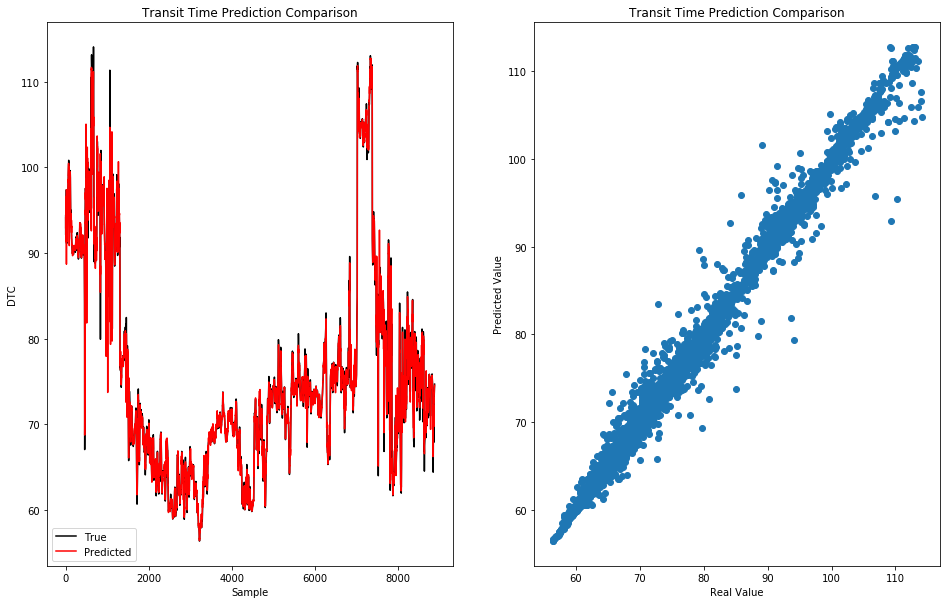

In [68]:
# Random Forest Model
#SVR(C=1000, gamma='auto', epsilon=.001)

dtc_RF=RandomForestRegressor(n_estimators=500, random_state=100)
dtc_RF.fit(X_train, y_train)
DTC_predict_train=dtc_RF.predict(x_trainwellDTC)
print('The correlation score is:',r2_score(DTC_predict_train, DTC_trainwell1))
result_plot(DTC_predict_train, DTC_trainwell1)
#result_plot(my_RF.predict(X_test), y_test)

In [69]:
# seperate the features and targets dts
df_train_data = np.array(data_train_dts)
x_trainwellDTS = df_train_data[:,:-1]
DTS_trainwell1 = df_train_data[:,-1]

# features scaling
scaler = StandardScaler()
x_trainwellDTS = scaler.fit_transform(x_trainwellDTS)

# train test split for DTC
X_train, X_test, y_train, y_test = train_test_split(x_trainwellDTS, DTS_trainwell1, test_size=0.2, random_state=100)

The correlation score is: 0.9886897374468371
Root Mean Square Error is: 2.54974


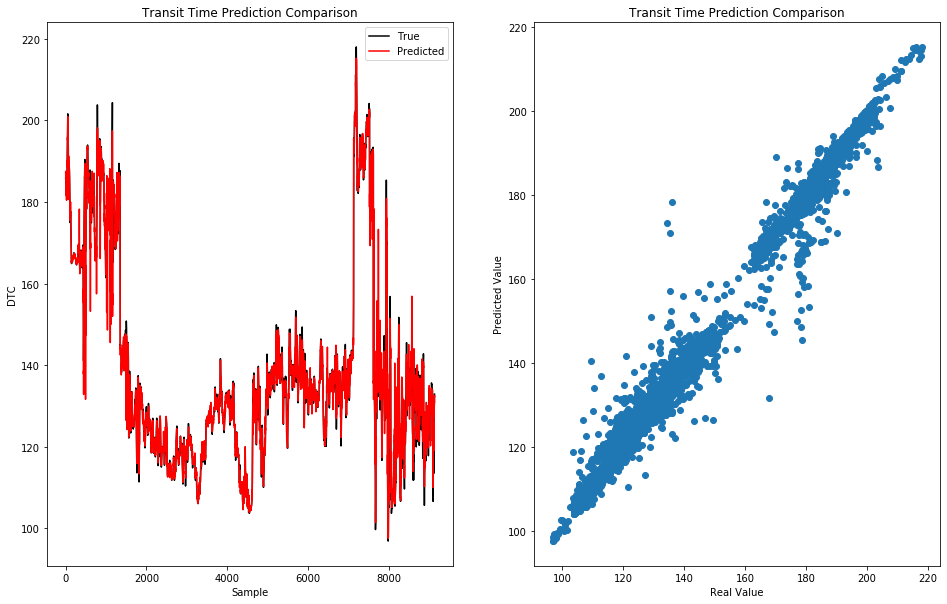

In [70]:
# Random Forest Model
#SVR(C=1000, gamma='auto', epsilon=.001)
dts_RF=RandomForestRegressor(n_estimators=500, random_state=100)
dts_RF.fit(X_train, y_train)
DTS_predict_train=dts_RF.predict(x_trainwellDTS)
print('The correlation score is:',r2_score(DTS_predict_train, DTS_trainwell1))
result_plot(DTS_predict_train, DTS_trainwell1)
#result_plot(my_RF.predict(X_test), y_test)

# Well Test 20%

In [71]:
# data reading
data = pd.read_csv('real_result_20perc.csv')
#temp_GR=data['GR']
#temp_GR[data['GR']>1000]=data['GR'].std()
#temp_HRM=data['HRM']
#temp_HRM[data['HRM']>30000]=data['HRM'].std()
#data['GR']=temp_GR
#data['HRM']=temp_HRM


data_test20_dtc=data[['CAL','CNC','GR','HRD','HRM','PE','ZDEN','DTC']]
data_test20_dtc.replace(['-999', -999], np.NaN, inplace=True)
data_test20_dtc.dropna(axis=0, inplace=True)

data_test20_dts=data[['CAL','CNC','GR','HRD','HRM','PE','ZDEN','DTS']]
data_test20_dts.replace(['-999', -999], np.NaN, inplace=True)
data_test20_dts.dropna(axis=0, inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4172: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [72]:
# Outliers detection dtc
dbscan_data=data_test20_dtc
dbscan_data=dbscan_data.values.astype('float32',copy=False)
dbscan_data_scaler=StandardScaler().fit(data_test20_dtc)
dbscan_data_transformed=dbscan_data_scaler.transform(data_test20_dtc)
model=DBSCAN(eps=5, min_samples=12,metric='euclidean').\
    fit(dbscan_data_transformed)
# Outliers removal
outliers_df=data_test20_dtc[model.labels_ == -1]
clusters_df=data_test20_dtc[model.labels_ != -1]
#data_test20_dtc[model.labels_ == -1]=np.NaN
#data_test20_dtc.dropna(axis=0, inplace=True)

In [73]:
outliers_df

,CAL,CNC,GR,HRD,HRM,PE,ZDEN,DTC
260,8.6484,0.1080,12.0053,196.7862,62290.7695,5.8187,2.4252,70.9457
359,8.7031,0.4450,583.8194,0.0911,31412.9609,12.6080,2.9345,95.2443
629,8.7031,0.4314,584.1155,0.1910,0.1548,12.2207,2.7913,92.2315
674,8.7656,0.0834,22.1688,69.5161,62290.7695,11.0195,2.5866,74.3735
803,8.6250,0.1112,12.2609,140.5485,62290.7695,6.0851,2.4779,69.5807
1138,8.7656,0.0927,18.9558,56.1927,62290.7695,10.4834,2.6372,73.7541
1485,8.7813,0.4470,806.8031,0.0977,29.3712,13.7410,3.0069,97.9099
1524,8.6250,0.1112,14.6066,62.2314,62290.7695,7.7286,2.6087,70.6896
1893,8.7031,0.4411,618.0795,0.0861,0.7721,12.5479,2.9238,93.9408
2088,8.6719,0.3596,1000.8920,0.0865,0.6068,12.9015,2.9828,101.2428


In [74]:
#outliers_df=np.mean(data_test20_dts[model.labels_ != -1])
data_test20_dtc[model.labels_ == -1]['CAL']=outliers_df['CAL']
data_test20_dtc[model.labels_ == -1]['CNC']=outliers_df['CNC']
outliers_df['GR'][outliers_df['GR']>np.max(clusters_df['GR'])]=np.max(clusters_df['GR'])
data_test20_dtc[model.labels_ == -1]['GR']=outliers_df['GR']
outliers_df['HRD'][outliers_df['HRD']>np.max(clusters_df['HRD'])]=np.max(clusters_df['HRD'])
data_test20_dtc[model.labels_ == -1]['HRD']=outliers_df['HRD']
outliers_df['HRM'][outliers_df['HRM']>np.max(clusters_df['HRM'])]=np.max(clusters_df['HRM'])
data_test20_dtc[model.labels_ == -1]['HRM']=outliers_df['HRM']
data_test20_dtc[model.labels_ == -1]['PE']=outliers_df['PE']
data_test20_dtc[model.labels_ == -1]['ZDEN']=outliers_df['ZDEN']
data_test20_dtc[model.labels_ == -1]['DTC']=outliers_df['DTC']

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:8767: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: h

In [75]:
# Outliers detection dts
dbscan_data=data_test20_dts
dbscan_data=dbscan_data.values.astype('float32',copy=False)
dbscan_data_scaler=StandardScaler().fit(data_test20_dts)
dbscan_data_transformed=dbscan_data_scaler.transform(data_test20_dts)
model=DBSCAN(eps=5, min_samples=12,metric='euclidean').\
    fit(dbscan_data_transformed)
# Outliers removal
outliers_df=data_test20_dts[model.labels_ == -1]
clusters_df=data_test20_dts[model.labels_ != -1]
#data_test20_dts[model.labels_ == -1]=np.NaN
#data_test20_dts.dropna(axis=0, inplace=True)

In [76]:
data_test20_dtc.describe()

,CAL,CNC,GR,HRD,HRM,PE,ZDEN,DTC
count,2217.000000,2217.000000,2217.000000,2217.000000,2217.000000,2217.000000,2217.000000,2217.000000
mean,8.634826,0.158620,30.183575,4.330621,159.877128,7.360546,2.476402,76.716787
std,0.044438,0.090789,49.952910,8.867523,3028.987218,1.255721,0.150628,14.257791
min,8.500000,0.009800,1.235100,0.086100,0.154800,4.780900,2.033400,53.164700
25%,8.625000,0.092000,8.535300,1.770200,1.857600,6.526200,2.377200,66.169800
50%,8.625000,0.128900,19.375200,2.772100,3.197000,7.881300,2.535500,71.417900
75%,8.671900,0.214200,37.201300,4.511500,5.029100,8.308300,2.582500,85.807000
max,8.781300,0.543400,1000.892000,196.786200,62290.769500,13.741000,3.006900,120.351200


In [77]:
data_test20_dts.describe()

,CAL,CNC,GR,HRD,HRM,PE,ZDEN,DTS
count,2217.000000,2217.000000,2217.000000,2217.000000,2217.000000,2217.000000,2217.000000,2217.000000
mean,8.634826,0.158620,30.183575,4.330621,159.877128,7.360546,2.476402,145.373654
std,0.044438,0.090789,49.952910,8.867523,3028.987218,1.255721,0.150628,44.345398
min,8.500000,0.009800,1.235100,0.086100,0.154800,4.780900,2.033400,86.306500
25%,8.625000,0.092000,8.535300,1.770200,1.857600,6.526200,2.377200,119.515300
50%,8.625000,0.128900,19.375200,2.772100,3.197000,7.881300,2.535500,130.290800
75%,8.671900,0.214200,37.201300,4.511500,5.029100,8.308300,2.582500,146.235700
max,8.781300,0.543400,1000.892000,196.786200,62290.769500,13.741000,3.006900,342.425400


In [78]:
#outliers_df=np.mean(data_test20_dts[model.labels_ != -1])
data_test20_dts[model.labels_ == -1]['CAL']=outliers_df['CAL']
data_test20_dts[model.labels_ == -1]['CNC']=outliers_df['CNC']
outliers_df['GR'][outliers_df['GR']>np.max(clusters_df['GR'])]=np.max(clusters_df['GR'])
data_test20_dts[model.labels_ == -1]['GR']=outliers_df['GR']
outliers_df['HRD'][outliers_df['HRD']>np.max(clusters_df['HRD'])]=np.max(clusters_df['HRD'])
data_test20_dts[model.labels_ == -1]['HRD']=outliers_df['HRD']
outliers_df['HRM'][outliers_df['HRM']>np.max(clusters_df['HRM'])]=np.max(clusters_df['HRM'])
data_test20_dts[model.labels_ == -1]['HRM']=outliers_df['HRM']
data_test20_dts[model.labels_ == -1]['PE']=outliers_df['PE']
data_test20_dts[model.labels_ == -1]['ZDEN']=outliers_df['ZDEN']
data_test20_dts[model.labels_ == -1]['DTS']=outliers_df['DTS']

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:8767: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: h

In [79]:
data_test20_dts.describe()

,CAL,CNC,GR,HRD,HRM,PE,ZDEN,DTS
count,2217.000000,2217.000000,2217.000000,2217.000000,2217.000000,2217.000000,2217.000000,2217.000000
mean,8.634826,0.158620,30.183575,4.330621,159.877128,7.360546,2.476402,145.373654
std,0.044438,0.090789,49.952910,8.867523,3028.987218,1.255721,0.150628,44.345398
min,8.500000,0.009800,1.235100,0.086100,0.154800,4.780900,2.033400,86.306500
25%,8.625000,0.092000,8.535300,1.770200,1.857600,6.526200,2.377200,119.515300
50%,8.625000,0.128900,19.375200,2.772100,3.197000,7.881300,2.535500,130.290800
75%,8.671900,0.214200,37.201300,4.511500,5.029100,8.308300,2.582500,146.235700
max,8.781300,0.543400,1000.892000,196.786200,62290.769500,13.741000,3.006900,342.425400


The correlation score is: 0.686732408647819
Root Mean Square Error is: 5.89013


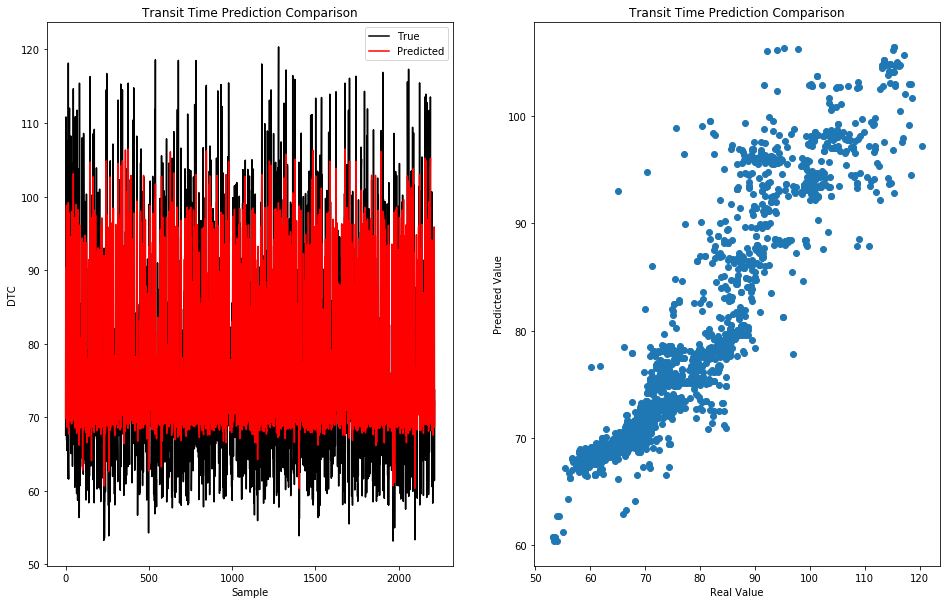

In [80]:
# seperate the features and targets dtc
df_test20_data = np.array(data_test20_dtc)
x_test20wellDTC = df_test20_data[:,:-1]
DTC_test20well1 = df_test20_data[:,-1]


# features scaling
scaler = StandardScaler()
x_test20wellDTC = scaler.fit_transform(x_test20wellDTC)

# Prediction of DTC
DTC_predict_test20=dtc_RF.predict(x_test20wellDTC)
DTC_predict_test20.shape
print('The correlation score is:',r2_score(DTC_predict_test20, DTC_test20well1))
#result_plot(DTS_predict, DTS_trainwell1)
result_plot(DTC_predict_test20, DTC_test20well1)

The correlation score is: -0.517917181128352
Root Mean Square Error is: 28.64911


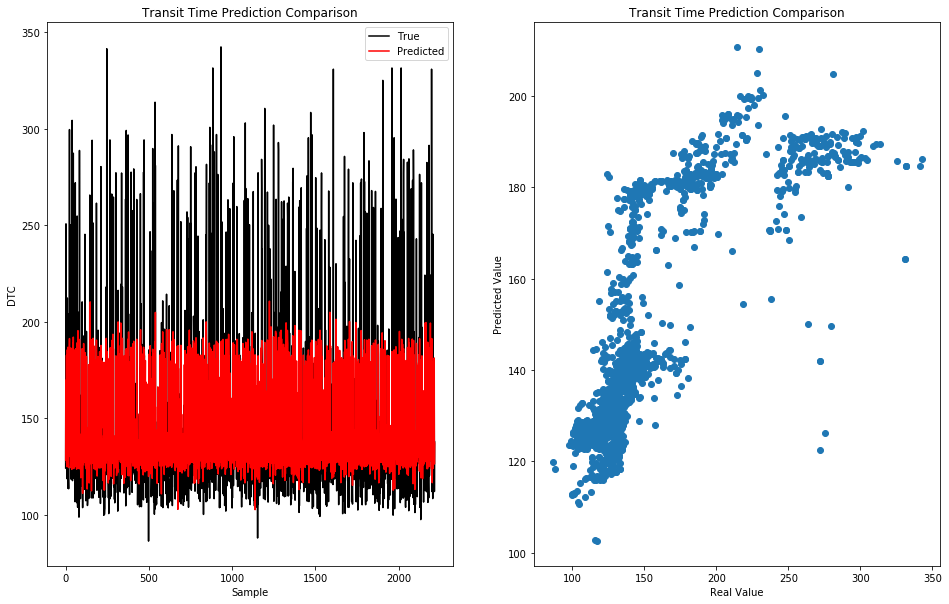

In [81]:
# seperate the features and targets dtc
df_test20_data = np.array(data_test20_dts)
x_test20wellDTS = df_test20_data[:,:-1]
DTS_test20well1 = df_test20_data[:,-1]


# features scaling
scaler = StandardScaler()
x_test20wellDTS = scaler.fit_transform(x_test20wellDTS)

# Prediction of DTC
DTS_predict_test20=dts_RF.predict(x_test20wellDTS)
DTS_predict_test20.shape
print('The correlation score is:',r2_score(DTS_predict_test20, DTS_test20well1))
#result_plot(DTS_predict, DTS_trainwell1)
result_plot(DTS_predict_test20, DTS_test20well1)

In [82]:
Elem_Square=np.square(DTS_predict_test20-DTS_test20well1)+np.square(DTC_predict_test20-DTC_test20well1)
well_test_RMS=0
for iterRMS in range(DTS_predict_test20.shape[0]):
    well_test_RMS=well_test_RMS+Elem_Square[iterRMS]
well_test_RMS=np.sqrt(well_test_RMS/(2*DTS_predict_test20.shape[0]))
print(well_test_RMS)

20.681693427801747


# Well Test

In [83]:
# data reading
data = pd.read_csv('test.csv')
temp_GR=data['GR']
temp_GR[data['GR']>1000]=data['GR'].std()
temp_HRM=data['HRM']
temp_HRM[data['HRM']>30000]=data['HRM'].std()
data['GR']=temp_GR
data['HRM']=temp_HRM


data_testtest_dtc=data[['CAL','CNC','GR','HRD','HRM','PE','ZDEN']]
data_testtest_dtc.replace(['-999', -999], np.NaN, inplace=True)
data_testtest_dtc.dropna(axis=0, inplace=True)

data_testtest_dts=data[['CAL','CNC','GR','HRD','HRM','PE','ZDEN']]
data_testtest_dts.replace(['-999', -999], np.NaN, inplace=True)
data_testtest_dts.dropna(axis=0, inplace=True)


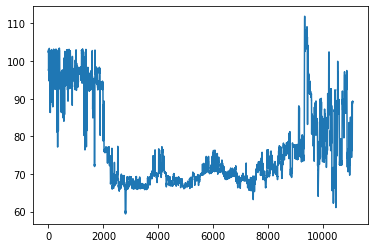

In [84]:
# seperate the features and targets dtc
x_testtestwellDTC = np.array(data_testtest_dtc)

# features scaling
scaler = StandardScaler()
x_testtestwellDTC = scaler.fit_transform(x_testtestwellDTC)

# Prediction of DTC
DTC_predict_testtest=dtc_RF.predict(x_testtestwellDTC)
DTC_predict_testtest.shape
plt.plot(DTC_predict_testtest)

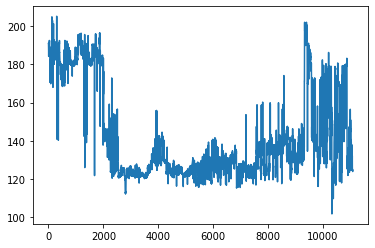

In [85]:
# seperate the features and targets dts
x_testtestwellDTS = np.array(data_testtest_dts)

# features scaling
scaler = StandardScaler()
x_testtestwellDTS = scaler.fit_transform(x_testtestwellDTS)

# Prediction of DTS
DTS_predict_testtest=dts_RF.predict(x_testtestwellDTS)
DTS_predict_testtest.shape
plt.plot(DTS_predict_testtest)

In [86]:
output_result = pd.DataFrame({'DTC':DTC_predict_testtest, 'DTS':DTS_predict_testtest})
output_result.head()
output_result.to_csv(path_or_buf='./sample_submission_3.csv', index=False)